COMP3010 Assignment,
Team Name: 20713634,
Leaderboard Score: 0.19553

Importing packages

In [38]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

Preprocessing Data

In [54]:
# Function that loads data from file into dataframe
def load_data(file):
    df = pd.read_csv(file)
    return df

X1 = load_data('train.csv')

# Data augmentation creating a ratio between Tank width and length
X1['Tank W/L Ratio'] = X1['Tank Width (m)'] / X1['Tank Length (m)']

# Making sure that there are only valid entries in the Status column
X1 = X1[X1['Status'].isin(['Subcooled', 'Superheated'])].copy()

# Columns that need to be checked for negative values which are invalid
cols_to_check = ['Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)', 'Vapour Height (m)',
                     'BLEVE Height (m)', 'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
                     'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Sensor ID']

# Making sure no negatives in relative data entries
for col in cols_to_check:
    X1 = X1[X1[col] >= 0]

# Dropping number column
X1 = X1.drop(columns=['Unnamed: 0'])

# Filling in missing number entries with the median
number_columns = X1.select_dtypes(include=[np.number]).columns
X1[number_columns] = X1[number_columns].fillna(X1[number_columns].median())

# Filling in missing category entries with the mode
category_columns = X1.select_dtypes(include=['object']).columns
X1[category_columns] = X1[category_columns].fillna(X1[category_columns].mode().iloc[0])

# Removing duplicate rows
X1 = X1.drop_duplicates()

# Function to remove outliers by calculating the Interquartile Range
def limit_outliers(df):
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # If outliers exist those entries are replaced with the relative bounds to maximise training data
        df.loc[:, column] = np.where(df[column] < lower_bound, lower_bound,
                     np.where(df[column] > upper_bound, upper_bound, df[column]))
    return df

X1 = limit_outliers(X1)

# One-hot encoding status entries and converting values into binary
X1 = pd.get_dummies(X1, columns=['Status'], drop_first=True)
X1['Status_Superheated'] = X1['Status_Superheated'].astype(int)

# Encoding Obstacle Angle as sine and cosine
# Converting angles into radians first
radians = np.deg2rad(X1['Obstacle Angle'])
X1['Obstacle Angle Sin'] = np.sin(radians)
X1['Obstacle Angle Cos'] = np.cos(radians)

# Dropping original Obstacle Angle column
X1.drop(columns=['Obstacle Angle'], inplace=True)

# Creating new dataframe for scaling
X2 = X1

# One-hot encoding Sensor ID and converting values into binary
X2 = pd.get_dummies(X2, columns=['Sensor ID'], prefix='Sensor')

# Removing Sensor ID names that were converted from a float
X2.columns = [col.replace('.0', '') for col in X2.columns]

# Finding new columns made from one-hot encoding
sensor_columns = [col for col in X2.columns if col.startswith('Sensor_')]
X2[sensor_columns] = X2[sensor_columns].astype(int)

# Separating features that need scaling from those that don't and saving the original order
original_order = X2.columns.tolist()
features_to_leave = sensor_columns + ['Target Pressure (bar)', 'Liquid Ratio', 'Status_Superheated', 'Sensor Position Side', 'Tank W/L Ratio']
features_to_scale = X2.drop(columns=features_to_leave).columns.tolist()

# Scaling the features
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2[features_to_scale])

# Combining scaled and unscaled features
X2_scaled = np.concatenate([X2_scaled, X2[features_to_leave].values], axis=1)

# Making the dataframe with the correct names in order
X2 = pd.DataFrame(X2_scaled, columns=features_to_scale + features_to_leave)
X2 = X2[original_order]


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

Training Linear Regression Model

MAPE: 0.57267
R² Score: 0.79235


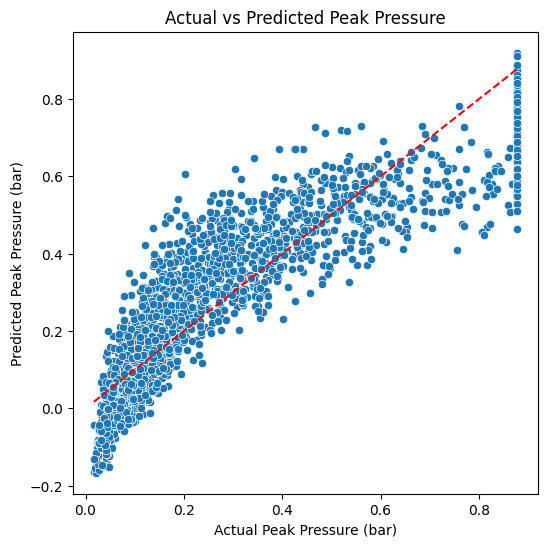

In [48]:
# Creating training data on scaled features
y = X2['Target Pressure (bar)']
X = X2.drop(columns=['Target Pressure (bar)'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Linear Regression Model
model = LinearRegression()

# Training model
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)
y_prediction_training = model.predict(X_train)

# Calculating Mean Average Percentage Error (MAPE) and R²
mape = mean_absolute_percentage_error(y_test, y_prediction)
mape_training = mean_absolute_percentage_error(y_train, y_prediction_training)
r2 = r2_score(y_test, y_prediction)

print(f'MAPE: {mape:.5f}')
print(f'R² Score: {r2:.5f}')

# Plotting the actual and predicted Peak Pressure
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Peak Pressure (bar)')
plt.ylabel('Predicted Peak Pressure (bar)')
plt.title('Actual vs Predicted Peak Pressure')
plt.show()

Testing Linear Regression Model

In [49]:
# Loading test data
test = pd.read_csv('test.csv')

# Preprocessing data so it matches the data the model was trained on
test['Tank W/L Ratio'] = test['Tank Width (m)'] / test['Tank Length (m)']
test = test.drop(columns=['Unnamed: 0'])
test = pd.get_dummies(test, columns=['Status'], drop_first=True)
test['Status_Superheated'] = test['Status_Superheated'].astype(int)
angles_rad = np.deg2rad(test['Obstacle Angle'])
test['Obstacle Angle Sin'] = np.sin(angles_rad)
test['Obstacle Angle Cos'] = np.cos(angles_rad)
test.drop(columns=['Obstacle Angle'], inplace=True)
test = pd.get_dummies(test, columns=['Sensor ID'], prefix='Sensor')
sensor_columns = [col for col in test.columns if col.startswith('Sensor_')]
test[sensor_columns] = test[sensor_columns].astype(int)
original_order = test.columns.tolist()
features_to_leave = sensor_columns + ['Liquid Ratio', 'Status_Superheated', 'Sensor Position Side', 'Tank W/L Ratio']
features_to_scale = test.drop(columns=features_to_leave).columns.tolist()
test_scaled = scaler.transform(test[features_to_scale])
test_scaled = np.concatenate([test_scaled, test[features_to_leave].values], axis=1)
test = pd.DataFrame(test_scaled, columns=features_to_scale + features_to_leave)
test = test[original_order]

# Predicting results using trained model
y_prediction = model.predict(test)

# Creating dataframe of predictions
predictions = pd.DataFrame({
    'ID': range(len(test)),
    'Target Pressure (bar)': y_prediction
})

# Creating CSV file of predictions
predictions.to_csv('lr_predictions.csv', index=False)

Linear Regression Prediction Performance

In [50]:
mape_test = 0.63624

# Creating prediction performance table
results = pd.DataFrame({
    'Dataset': ['Training Set', 'Validation Set', 'Test Set'],
    'MAPE': [mape_training, mape, mape_test]
})

print(results)

          Dataset     MAPE
0    Training Set  0.58080
1  Validation Set  0.57267
2        Test Set  0.63624


Training XGBoost Model

In [43]:
# Creating training data on original data with no scaling
X = X1.drop(columns=['Target Pressure (bar)'])
y = X1['Target Pressure (bar)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating XGBoost model
xgb_model = xgb.XGBRegressor(
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

# Creating Hyperparameter ranges for model
Hyperparameters = {

    # Number of trees
    'n_estimators': [100, 300, 600, 900, 1200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],

    # Fraction of data for each tree
    'subsample': [0.7, 0.8, 0.9, 1.0],

    # L1 regularisation
    'reg_alpha': [0, 0.1, 1]
}

# Creating Randomized Search Cross-Validation for finding best Hyperparameters
random_search = RandomizedSearchCV(
    xgb_model, Hyperparameters,

    # Number of Hyperparameter setting combinations to try
    n_iter=50,

    # Metric of testing best Hyperparameters
    scoring='r2',

    # Number of cross-validation folds
    cv=5,

    # Uses all CPUs for parallel processing
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Randomized Searching
random_search.fit(X_train, y_train)

print("Best R² Score:", random_search.best_score_)
print("Best Hyperparameters:", random_search.best_params_)

# Creating the model with the best hyperparameters from the search
best_xgb_model = random_search.best_estimator_

# Predicting results
y_prediction = best_xgb_model.predict(X_test)
y_prediction_training = best_xgb_model.predict(X_train)

# Calculating Mean Average Percentage Error (MAPE) and R²
mape = mean_absolute_percentage_error(y_test, y_prediction)
mape_training = mean_absolute_percentage_error(y_train, y_prediction_training)
r2 = r2_score(y_test, y_prediction)

print(f'MAPE: {mape:.5f}')
print(f'R² Score: {r2:.5f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best R² Score: 0.9627925090288434
Best Hyperparameters: {'subsample': 0.9, 'reg_alpha': 0.1, 'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.05}
MAPE: 0.11828
R² Score: 0.96986


Testing XGBoost Model

In [44]:
# Loading test data
test = pd.read_csv('test.csv')

# Preprocessing data so it matches the data the model was trained on
test = test.drop(columns=['Unnamed: 0'])
test['Tank W/L Ratio'] = test['Tank Width (m)'] / test['Tank Length (m)']
test = pd.get_dummies(test, columns=['Status'], drop_first=True)
test['Status_Superheated'] = test['Status_Superheated'].astype(int)
angles_rad = np.deg2rad(test['Obstacle Angle'])
test['Obstacle Angle Sin'] = np.sin(angles_rad)
test['Obstacle Angle Cos'] = np.cos(angles_rad)
test.drop(columns=['Obstacle Angle'], inplace=True)

# Predicting results using trained XGBoost model
y_prediction = best_xgb_model.predict(test)

# Creating dataframe of predictions
prediction = pd.DataFrame({
    'ID': range(len(test)),
    'Target Pressure (bar)': y_prediction
})

# Creating CSV file of predictions
prediction.to_csv('xgboost_predictions.csv', index=False)

XGBoost Model Prediction Performance

In [45]:
mape_test = 0.26832

# Creating prediction performance table
results = pd.DataFrame({
    'Dataset': ['Training Set', 'Validation Set', 'Test Set'],
    'MAPE': [mape_training, mape, mape_test]
})

print(results)

          Dataset      MAPE
0    Training Set  0.038808
1  Validation Set  0.118284
2        Test Set  0.268320


Training Deep Neural Network Model

In [51]:
# Creating training data
y = X2['Target Pressure (bar)']
X = X2.drop(columns = ['Target Pressure (bar)'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays for storing results
mape_scores = []
mape_training_scores = []
r2_scores = []

# Looping over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X_train)):

    # Creating training and validation split for the fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Creating Sequential model
    def create_model():
      model = Sequential()

      # Input Layer
      model.add(Input(shape=(X.shape[1],)))

      # Hidden Layers
      # L2 Regularisation to prevent overfitting
      # Batch Normalisation for generalisation
      model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(BatchNormalization())

      model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

      model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

      model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

      # Output Layer with Linear Activation for Regression
      model.add(Dense(1, activation='linear'))

      # Compiling model with Adam Optimiser
      model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=['mape'])
      return model

    # Creating the model
    model = create_model()

    # Creating an EarlyStopping callback to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100, batch_size=32,
        validation_data=(X_test_fold, y_test_fold),
        verbose=0,
        callbacks=[early_stop]
    )

    # Predicting results
    y_prediction = model.predict(X_test_fold).flatten()
    y_prediction_training = model.predict(X_train_fold).flatten()

    # Calculating MAPE and R²
    mape = mean_absolute_percentage_error(y_test_fold, y_prediction)
    mape_training = mean_absolute_percentage_error(y_train_fold, y_prediction_training)
    r2 = r2_score(y_test_fold, y_prediction)

    print(f'Fold {fold + 1} - MAPE: {mape:.5f}, R²: {r2:.5f}')

    # Storing scores
    mape_scores.append(mape)
    mape_training_scores.append(mape_training)
    r2_scores.append(r2)

# Calculating the averages of the Mean Average Percentage Error (Mape) and R²
average_mape = np.mean(mape_scores)
average_mape_training = np.mean(mape_training_scores)
average_r2 = np.mean(r2_scores)

print(f"Average MAPE score: {average_mape:.5f}")
print(f"Average R² score: {average_r2:.5f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 - MAPE: 0.13181, R²: 0.96437
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 - MAPE: 0.11498, R²: 0.97388
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 - MAPE: 0.11128, R²: 0.97726
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 - MAPE: 0.11591, R²: 0.97119
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 - MAPE: 0.11785, R²: 0.97369
Average MAPE score: 0.11837
Average R² score: 0.97208


Testing Deep Neural Network Model

In [52]:
# Loading test data
test = pd.read_csv('test.csv')

# Preprocessing data so it matches the data the model was trained on
test['Tank W/L Ratio'] = test['Tank Width (m)'] / test['Tank Length (m)']
test = test.drop(columns=['Unnamed: 0'])
test = pd.get_dummies(test, columns=['Status'], drop_first=True)
test['Status_Superheated'] = test['Status_Superheated'].astype(int)
angles_rad = np.deg2rad(test['Obstacle Angle'])
test['Obstacle Angle Sin'] = np.sin(angles_rad)
test['Obstacle Angle Cos'] = np.cos(angles_rad)
test.drop(columns=['Obstacle Angle'], inplace=True)
test = pd.get_dummies(test, columns=['Sensor ID'], prefix='Sensor')
sensor_columns = [col for col in test.columns if col.startswith('Sensor_')]
test[sensor_columns] = test[sensor_columns].astype(int)
original_order = test.columns.tolist()
features_to_leave = sensor_columns + ['Liquid Ratio', 'Status_Superheated', 'Sensor Position Side', 'Tank W/L Ratio']
features_to_scale = test.drop(columns=features_to_leave).columns.tolist()
test_scaled = scaler.transform(test[features_to_scale])
test_scaled = np.concatenate([test_scaled, test[features_to_leave].values], axis=1)
test = pd.DataFrame(test_scaled, columns=features_to_scale + features_to_leave)
test = test[original_order]

# Predicting results using trained model
y_prediction = model.predict(test).flatten()

# Creating dataframe of predictions
predictions = pd.DataFrame({
    'ID': range(len(test)),
    'Target Pressure (bar)': y_prediction
})

# Creating CSV file of predictions
predictions.to_csv('nn_predictions.csv', index=False)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Deep Neural Network Model Prediction Performance

In [53]:
mape_test = 0.19553

# Creating prediction performance table
results = pd.DataFrame({
    'Dataset': ['Training Set', 'Validation Set', 'Test Set'],
    'MAPE': [average_mape_training, average_mape, mape_test]
})

print(results)

          Dataset      MAPE
0    Training Set  0.099534
1  Validation Set  0.118366
2        Test Set  0.195530
